1. Currently distractors are not hard enough cuz a simple strategy that measures token-level overlap can achieve 70% F1 on the filter task
2. Sadly the trained model did no better than this.
3. Analysis of the failure cases of model & token-level overlap strategy suggests that **a)** model does have preferences for choosing facts with high overlap with the question but it's not always true. **b)** The model did develop additional strategies which allow it to recover performance where the token-level overlap strategy falls short. But such additional skills compromise performance somewhere else. Thus, from a global point of view, filter F1 didn't get improved.

Takeaways:
- It is necessary to include token-level overlap strategy as a baseline
- Hard distractors must also have strong overlap with the question, so as to make comparing token-level overlap insufficient.
- We expect the model to learn additional skills where overlap strategy falls short, **without losing** the ability to carry out what such simple strategy can do.

In [1]:
import json, random, os
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pickle
import pylcs
import copy

In [2]:
np.set_printoptions(precision=4)

In [3]:
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

In [5]:
#txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_J.json", "r"))
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/output_mine_all_schema.json", "r"))

print(len(txt_dataset))

7921


In [6]:
Counter([len(txt_dataset[k]['SupportingFacts']) for k in txt_dataset]) # 3.5% num_gold != 2

Counter({2: 7657, 3: 245, 4: 19})

In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

In [8]:
# For the purpose of measuring token-level overlap
### Processing: only did stopwords removal + tokenization
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    remove_stop_a = pattern.sub('', a)
    bow_a = tokenizer.tokenize(remove_stop_a) #normalize_text(a).split()
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        remove_stop_c = pattern.sub('', c)
        bow_c = tokenizer.tokenize(remove_stop_c) #normalize_text(c).split()
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)

In [9]:
# For each sample, compute overlap metrics between Q and all facts respectively

guid2posMetrics = defaultdict(lambda: defaultdict(lambda: []))
guid2negMetrics = defaultdict(lambda: defaultdict(lambda: []))
zero_pos = 0
count = 0
for k in txt_dataset:
    count += 1
    if count%1000 == 0: print(k)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
    if len(txt_dataset[k]['SupportingFacts']) == 0: 
        zero_pos += 1
        continue
    for f in txt_dataset[k]['SupportingFacts']:
        F1, _, __, RE, PR = compute_vqa_metrics([f['fact']], q)
        lcs = pylcs.lcs2(q, f['fact'])
        lcs_f = lcs / len(f['fact'])
        lcs_q = lcs / len(q)
        guid2posMetrics[guid]['F1'].append(F1)
        guid2posMetrics[guid]['RE'].append(RE)
        guid2posMetrics[guid]['PR'].append(PR)
        guid2posMetrics[guid]['lcs_q'].append(lcs_q)
        guid2posMetrics[guid]['lcs_f'].append(lcs_f)
        
    for d in txt_dataset[k]['DistractorFacts']:
        F1, _, __, RE, PR = compute_vqa_metrics([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics[guid]['F1'].append(F1)
        guid2negMetrics[guid]['RE'].append(RE)
        guid2negMetrics[guid]['PR'].append(PR)
        guid2negMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics[guid]['lcs_f'].append(lcs_f)
assert set(guid2posMetrics.keys()) == set(guid2negMetrics.keys())
print(zero_pos)

999
1999
2999
3999
4999
5999
6999
0


In [11]:
# Take a random look. Every fact has 5 overlap scores with the corresponding question (F1, RE, PR, lcs_q, lcs_f)
for k in txt_dataset:
    if random.random() > 3/7921: continue
    print(k)
    print('Q: ', txt_dataset[k]['Q'])
    print('A: ', txt_dataset[k]['A'])
    print('+')
    for i, f in enumerate(txt_dataset[k]['SupportingFacts']):
        print(i, f['fact'])
        print(compute_vqa_metrics([f['fact']], txt_dataset[k]['Q']))
    print('-')
    for i, d in enumerate(txt_dataset[k]['DistractorFacts']):
        print(i, d['fact'])
        print(compute_vqa_metrics([d['fact']], txt_dataset[k]['Q']))
    print('  ------------------------------------------------------------  \n')

5129
Q:  Was the 2002 Men's Hockey World Cup held in the same country as the tournament held by the International Basketball Federation in 2002?
A:  No, as one was held in the USA and the other was held in Malyasia.
+
0 The tournament held by the International Basketball Federation in Indianapolis, Indiana, United States from August 29 to September 8, 2002. At the start of tournament, all 16 participating countries had 12 players on their roster. The following nations' teams competed:
(0.2222184329192391, 0.2222184329192391, 0, 0.4375, 0.14893617021276595)
1 The 2002 Men's Hockey World Cup was the 10th edition of the Hockey World Cup, a men's field hockey tournament. It was held from 24 February to 9 March 2002 in Kuala Lumpur, Malaysia. Germany won their first title after defeating Australia 2–1 in the final.
(0.2608660029892024, 0.2608660029892024, 0, 0.5625, 0.16981132075471697)
-
0 The 2002 FIBA World Championship was the 14th edition of the competition now known as the FIBA Basket

F1 0.4902158818331019
RE 0.43214240626183564
PR 0.45474056306021965
lcs_q 0.41181668981189246
lcs_f 0.40095947481378613


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


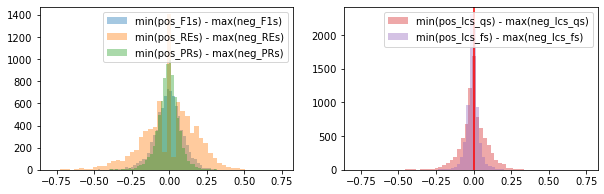

In [10]:
# posdominate
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [min(guid2posMetrics[guid][m]) - max(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="min(pos_{}s) - max(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [min(guid2posMetrics[guid][m]) - max(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="min(pos_{}s) - max(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

F1 0.9655346547153137
RE 0.9704582754702689


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


PR 0.9584648402979422
lcs_q 0.9599798005302361
lcs_f 0.9383916172200479


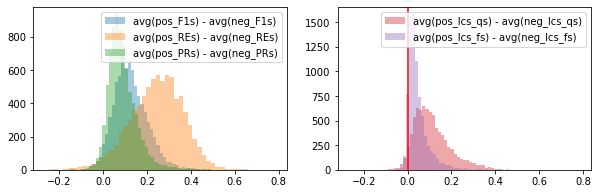

In [11]:
# avg(pos) - avg(neg)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


F1 0.810564893213699
RE 0.8053835460634399
PR 0.7880702641223304
lcs_q 0.7975483381776823
lcs_f 0.7492733476557564


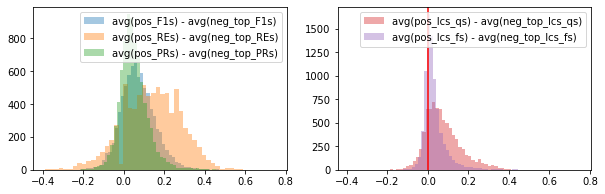

In [53]:
# avg(pos) - avg(neg_top)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

In [24]:
def compute_retrieval_metrics(pred, gth):
    common = len(set(pred).intersection(gth))
    RE = common / len(gth)
    PR = common / len(pred)
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

In [25]:
# Performance of top2<m> strategy
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.7173657038219061
   RE =  0.7140117994100295
   PR =  0.7225663716814159
RE
   F1 =  0.6812806664913325
   RE =  0.6781394858828487
   PR =  0.6861567635903919
PR
   F1 =  0.6939523575011564
   RE =  0.6906236831015593
   PR =  0.6991150442477876
lcs_q
   F1 =  0.6624480429737595
   RE =  0.6593025705857564
   PR =  0.6673198482932996
lcs_f
   F1 =  0.6585794988220267
   RE =  0.6553518752633797
   PR =  0.663590391908976


In [38]:
### Categorization based on overlap patterns between question & facts
m = 'F1'
buckets = defaultdict(lambda: [])
for guid in guid2posMetrics:
    all_scores = np.array(guid2posMetrics[guid][m]+guid2negMetrics[guid][m])
    if len(guid2posMetrics[guid][m]) == 0: 
        continue
    if set(all_scores.argsort()[-2:]) == {0,1}:
        buckets['posdominate'].append(guid)
    if (0 not in all_scores.argsort()[-2:]) and (1 not in all_scores.argsort()[-2:]):
        buckets['negdominate'].append(guid)
    if (all_scores.argsort()[-1] in {0,1}) and (bool(0 in all_scores.argsort()[-3:]) != bool(1 in all_scores.argsort()[-3:])):
        buckets['top&lag'].append(guid)
    if (set(all_scores.argsort()[-3::2]) == {1,0}) or ((not set(all_scores.argsort()[-2:]) == {0,1}) and (all_scores.argsort()[-2:][0] in {0,1})):
        buckets['mixed'].append(guid)

for k in buckets:
    print(k, len(buckets[k]))


posdominate 3866
mixed 2166
top&lag 1385
negdominate 493


### Recover model predictions on each sample

In [79]:
# Combine filter model outputs on val+te
light_output_dir = "/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/filter_full_data/"
step = 5
txt_prediction = json.load(open(os.path.join(light_output_dir, "ind_test|ood_test_-1_step{}_txt_20_True_txt_dataset_J.json".format(step)), "r")) 
print(len(txt_prediction))
txt_prediction.update(json.load(open(os.path.join(light_output_dir, "val_-1_step{}_txt_20_True_txt_dataset_J.json".format(step)), "r")))
print(len(txt_prediction))

1594
2387


In [89]:
indx2guid = dict(zip([i for i in txt_dataset], [txt_dataset[i]['Guid'] for i in txt_dataset]))

txt_guid2pred = {}
for indx in txt_prediction:
    i = str(indx2guid[indx])
    try:
        txt_guid2pred[i] = {"gth": [], "gth_f": [], "pred": [], "pred_f": []}
        for c in np.array(txt_prediction[indx]['pred_scores'][:len(txt_prediction[indx]['choices'])]).argsort()[-2:]:
            txt_guid2pred[i]['pred_f'].append(txt_prediction[indx]['choices'][c])
            txt_guid2pred[i]['pred'].append(c)
        for inx, l, f in zip(range(len(txt_prediction[indx]['labels'])), txt_prediction[indx]['labels'], txt_prediction[indx]['choices']):
            if l == 1:
                txt_guid2pred[i]['gth'].append(inx)
                txt_guid2pred[i]['gth_f'].append(f)
        F1, RE, PR = compute_retrieval_metrics(txt_guid2pred[i]['pred'], txt_guid2pred[i]['gth'])
        txt_guid2pred[i]['F1'] = F1
        txt_guid2pred[i]['RE'] = RE
        txt_guid2pred[i]['PR'] = PR
        txt_guid2pred[i]['indx'] = indx
    except:
        txt_guid2pred[i]['F1'] = 0.0
        txt_guid2pred[i]['RE'] = 0.0
        txt_guid2pred[i]['PR'] = 0.0
        txt_guid2pred[i]['indx'] = indx
        print(indx)
print(len(txt_guid2pred))
#pickle.dump(txt_guid2pred, open(os.path.join(light_output_dir, "guid2pred_val|ind_test|ood_test_-1_step{}_txt_20_True_txt_dataset_J.pkl".format(step)), "wb"))

6886
6927
5649
2387


In [90]:
txt_guid2pred = pickle.load(open(os.path.join(light_output_dir, "guid2pred_val|ind_test|ood_test_-1_step{}_txt_20_True_txt_dataset_J.pkl".format(step)), "rb"))

### recover pred_f (pred_f in the prediction files are tokenized.)
txt_guid2pred_recovered = copy.deepcopy(txt_guid2pred)
for k in txt_dataset:
    if int(k) % 1000 == 0: print(k)
    guid = txt_dataset[k]['Guid']
    if str(guid) not in txt_guid2pred: continue
    ori = len(txt_guid2pred_recovered[str(guid)]['pred_f'])
    txt_guid2pred_recovered[str(guid)]['pred_f'] = []
    for pred_f in txt_guid2pred[str(guid)]['pred_f']:
        best_f1 = 0
        nearest_f = ""
        for f in txt_dataset[k]['SupportingFacts'] + txt_dataset[k]['DistractorFacts']:
            F1, _, __, RE, PR = compute_vqa_metrics([pred_f], f['fact'])
            if F1 > best_f1:
                best_f1 = F1
                nearest_f = f['fact']
        txt_guid2pred_recovered[str(guid)]['pred_f'].append(nearest_f)
    assert len(txt_guid2pred_recovered[str(guid)]['pred_f']) == ori

0
1000
2000
3000
4000
5000
6000
7000


In [91]:
pickle.dump(txt_guid2pred_recovered, open(os.path.join(light_output_dir, "guid2pred_val|ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J_recovered.pkl".format(step)), "wb"))

In [75]:
# Take a random look at model predictions (structured in a way for friendly to later analysis)
for i in txt_guid2pred_recovered:
    if random.random() < 0.001:
        print(i)
        pprint(txt_guid2pred_recovered[i])

79d0e7ad-cfaa-4215-8ed0-1034a8564ef3
{'F1': 0.9999950000249999,
 'PR': 1.0,
 'RE': 1.0,
 'gth': [3, 6],
 'gth_f': ["The Innuitian Region is a physiographic division of Canada ' s far "
           'north . It is one of three physiographic divisions of the Arctic '
           'Lands physiographic region , along with the Arctic Coastal Plain , '
           'and the Arctic Lowlands . The Queen Elizabeth Islands comprise '
           'most of the region , which is also considered to be part of the '
           'Arctic Archipelago .',
           'The Arctic Cordillera is a terrestrial ecozone in northern Canada '
           'characterized by a vast , deeply dissected chain of mountain '
           'ranges extending along the northeastern flank of the Canadian '
           'Arctic Archipelago from Ellesmere Island to the northeasternmost '
           'part of the Labrador Peninsula in northern Labrador and northern '
           'Quebec , Canada .'],
 'indx': '7103',
 'pred': [3, 6],
 'pred_f'

In [93]:
# Model performance filter F1
# This is slightly better than the reported number in overleaf, which is resulted from threshold=0.15 w/o top2.
# Filter metrics here correspond to threshold=0.0 w/ top2
# The threshold was selected because it leads to higher F1 for the joint model
print(np.mean([txt_guid2pred_recovered[g]['F1'] for g in txt_guid2pred_recovered]))
print(np.mean([txt_guid2pred_recovered[g]['RE'] for g in txt_guid2pred_recovered]))
print(np.mean([txt_guid2pred_recovered[g]['PR'] for g in txt_guid2pred_recovered]))

0.7750964185692016
0.7710515291160452
0.7813154587348136


### Categorization of questions based on overlapping patterns. 
### Investigation into whether it relates to a notion of difficulty

In [97]:
# Performance breakdown w.r.t overlapping patterns
count = 0
pred_count = 0
m = 'F1'
cased_F1s = []
for k in txt_dataset:
    guid = txt_dataset[k]['Guid']
    if len(guid2posMetrics[guid][m]) == 0: 
        continue
    all_scores = np.array(guid2posMetrics[guid][m]+guid2negMetrics[guid][m])
    #if (0 in all_scores.argsort()[-2:]) and (1 in all_scores.argsort()[-2:]): ## pos dominate
    #if (0 not in all_scores.argsort()[-2:]) and (1 not in all_scores.argsort()[-2:]): ## negdominate
    if (set(all_scores.argsort()[-3::2]) == {1,0})or ((not set(all_scores.argsort()[-2:]) == {0,1}) and (all_scores.argsort()[-2:][0] in {0,1})): ## Mixed
    #if (all_scores.argsort()[-1] in {0,1}) and (bool(0 in all_scores.argsort()[-3:]) != bool(1 in all_scores.argsort()[-3:])): ## head&toes
    #if (set(all_scores.argsort()[-4::3]) == {1,0}): ## head&toes' children
        count += 1

        if str(guid) in txt_guid2pred_recovered:
            cased_F1s.append(txt_guid2pred_recovered[str(guid)]['F1'])
            pred_count += 1
        if (not str(guid) in txt_guid2pred_recovered) or random.random() > 0.001: continue
        
        print(" ----------------------------------------- ")
        print('Q: ', txt_dataset[k]['Q'])
        print('A: ', txt_dataset[k]['A'])
        print("PRED: ", txt_guid2pred_recovered[str(guid)]['pred_f'][0])
        print("PRED: ", txt_guid2pred_recovered[str(guid)]['pred_f'][1])
        print('+')
        for f, F1, RE, PR in zip(txt_dataset[k]['SupportingFacts'], guid2posMetrics[guid]['F1'], guid2posMetrics[guid]['RE'], guid2posMetrics[guid]['PR']):
            
            print(F1, f['fact'])
            print(RE, PR)
        print('-')
        for d, F1, RE, PR in zip(txt_dataset[k]['DistractorFacts'], guid2negMetrics[guid]['F1'], guid2negMetrics[guid]['RE'], guid2negMetrics[guid]['PR']):
            if d['fact'] in txt_guid2pred_recovered[str(guid)]['pred_f']:
                print(F1, d['fact'])
                print(RE, PR)
print(count)
print(pred_count)
print(np.mean(cased_F1s))

2166
650
0.6866106109774817


In [102]:
### Agreement between Top2<m> & model prediction
m = 'F1'
F1s = []
for k in txt_dataset:
    guid = txt_dataset[k]['Guid']
    if str(guid) not in txt_guid2pred_recovered: continue
    if len(guid2posMetrics[guid][m]) == 0: 
        print('continue')
        continue
    all_scores =  np.array(guid2posMetrics[guid][m] + guid2negMetrics[guid][m])
    #if (0 in all_scores.argsort()[-2:]) and (1 in all_scores.argsort()[-2:]): ## posdominate
    if (0 not in all_scores.argsort()[-2:]) and (1 not in all_scores.argsort()[-2:]): ## negdominate
    #if (set(all_scores.argsort()[-3::2]) == {1,0})or ((not set(all_scores.argsort()[-2:]) == {0,1}) and (all_scores.argsort()[-2:][0] in {0,1})): # Mixed
    #if (all_scores.argsort()[-1] in {0,1}) and (bool(0 in all_scores.argsort()[-3:]) != bool(1 in all_scores.argsort()[-3:])): ## head&toes
    #if (set(all_scores.argsort()[-3::2]) == {1,0}): ## Mixed's children
    #if ((not set(all_scores.argsort()[-2:]) == {0,1}) and (all_scores.argsort()[-2:][0] in {0,1})): ## Mixed's children
    #if True: ## Overall
        m_pred = all_scores.argsort()[-2:]
        all_facts = txt_dataset[k]['SupportingFacts'] + txt_dataset[k]['DistractorFacts']
        common = 0
        for c in m_pred:
            if all_facts[c]['fact'] in txt_guid2pred_recovered[str(guid)]['pred_f']:
                common += 1
        if common == 0:
            F1s.append(0)
            
        elif common ==1:
            F1s.append(0.5)
            if random.random() < 0.01:
                print(" ----------------------------------------- ")
                print('Q: ', txt_dataset[k]['Q'])
                print('A: ', txt_dataset[k]['A'])
                print("PRED: ", txt_guid2pred_recovered[str(guid)]['pred_f'][0])
                print("PRED: ", txt_guid2pred_recovered[str(guid)]['pred_f'][1])
                #try:
                    #print("--", all_facts[m_pred[0]]['fact'])
                    #print("--", all_facts[m_pred[1]]['fact'])
                #except: pass
                i = 0
                print('+')
                for f, F1, RE, PR in zip(txt_dataset[k]['SupportingFacts'], guid2posMetrics[guid]['F1'], guid2posMetrics[guid]['RE'], guid2posMetrics[guid]['PR']):
                    if i in m_pred:
                        print(F1, f['fact'])
                        print(RE, PR)
                    i += 1
                print('-')
                for d, F1, RE, PR in zip(txt_dataset[k]['DistractorFacts'], guid2negMetrics[guid]['F1'], guid2negMetrics[guid]['RE'], guid2negMetrics[guid]['PR']):
                    if i in m_pred:
                        print(F1, d['fact'])
                        print(RE, PR)
                    i += 1
        elif common == 2:
            F1s.append(1)
            
        else:
            print("wtf???")
print(len(F1s))
print(np.mean(F1s))

continue
 ----------------------------------------- 
Q:  What is a nerve cell made of?
A:  A body (soma), dendrites, and a single axon.
PRED:  This process is called sensory transduction. The cell bodies of the sensory neurons are located in the dorsal ganglia of the spinal cord. This sensory information travels along afferent nerve fibers in an afferent or sensory nerve, to the brain via the spinal cord.
PRED:  There are many different types of cell in the human body . basal cell (stem cell) of cornea, tongue, mouth, nasal cavity, distal anal canal, distal urethra, and distal vagina There are nerve cells, also known as neurons, present in our human body. They are branched out. These cells make up nervous tissue .
+
-
0.10526087262579169 The cell bodies of the sensory neurons are located in the dorsal ganglia of the spinal cord. This sensory information travels along afferent nerve fibers in an afferent or sensory nerve, to the brain via the spinal cord.
0.4 0.06060606060606061
0.08888